In [1]:
# not strictly necessary, but imported anyway for the IDE haha
import torch
from torchvision import datasets, transforms 

No of images in training set: 835
No of images in validation set: 104
No of images in test set: 105
No of images in feeder set: 15079
Labels: ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
Labels (feeder): ['blueTit', 'chaffinchF', 'chaffinchM', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']


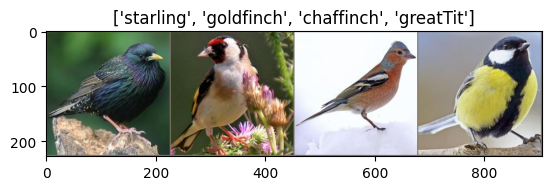

In [2]:
%run setup.ipynb # should take like 20 seconds i think

# Training with augmentation

Now we've trained our model and assessed its performance on the feeder data... it's not the worst, but let's see if we can't make it a bit stronger by adding augmentations.

## Augmentation round 1

First, just gonna mess up the pictures a little - no sciency arguments for it other than intuitively trying to capture that the feeder images are more grainy and the birds are not always perfectly posed (hence the crop).

In [ ]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation1 = transforms.Compose([
    transforms.ColorJitter(brightness=0.1),
    transforms.GaussianBlur(kernel_size=(5,5), sigma=(7, 9)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the scale at 30 % of og img to not get too small portions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
# FIXME should we in actuality be ADDING the augmented and the non-augmented dataset together?
dataset_train_aug1 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation1)
normal_and_aug1 = torch.utils.data.ConcatDataset([dataset_train, dataset_train_aug1]) # FIXME
dataloader_train_aug1 = torch.utils.data.DataLoader(dataset_train_aug1, batch_size=4, shuffle=True, num_workers=4)
# NOTE: no augs on the validation, righT?
#dataset_val_aug1 = datasets.ImageFolder(PATH_VAL, preprocess_with_augmentation1)
#dataloader_val_aug1 = torch.utils.data.DataLoader(dataset_val_aug1, batch_size=4, shuffle=True, num_workers=4)

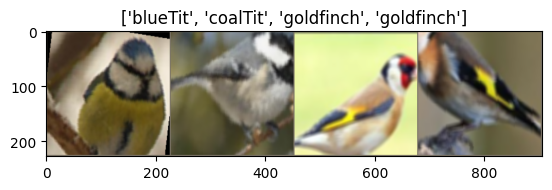

In [4]:
# looking at the augmentations..
inputs, classes = next(iter(dataloader_train_aug1))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_labels[x] for x in classes])

Load in a fresh ResNet50 that's prepped for transfer learning

In [6]:
# load "clean" resnet50
untrained_model_aug1 = load_and_prep_resnet50()
optimizer = get_optimizer(untrained_model_aug1) # FIXME does this change?

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training
First with the frozen layers, then unfreeze for finetuning

In [ ]:
freezetrained_model_aug1, _ = train_model(model=untrained_model_aug1, optimizer=optimizer, num_epoch=5, train=dataloader_train_aug1)

Epoch 1/5
----------
Train Loss: 1.7923 Acc: 0.3461
Val Loss: 1.7714 Acc: 0.4231
Epoch time 1m 15s
----------

Epoch 2/5
----------
Train Loss: 1.5387 Acc: 0.5557
Val Loss: 1.6119 Acc: 0.5288
Epoch time 2m 33s
----------

Epoch 3/5
----------
Train Loss: 1.3851 Acc: 0.6084
Val Loss: 1.5637 Acc: 0.5385
Epoch time 3m 54s
----------

Epoch 4/5
----------
Train Loss: 1.2435 Acc: 0.6766
Val Loss: 1.4377 Acc: 0.6250
Epoch time 5m 10s
----------

Epoch 5/5
----------
Train Loss: 1.1204 Acc: 0.7006
Val Loss: 1.3366 Acc: 0.6250
Epoch time 6m 33s
----------

Training complete in 6m 33s
Validation accuracies:
[0.4230769230769231, 0.5288461538461539, 0.5384615384615384, 0.625, 0.625]


In [9]:
unfreeze_layers(freezetrained_model_aug1)
model_aug1, model_aug1_info = train_model(model=freezetrained_model_aug1, optimizer=optimizer, num_epoch=5, train=dataloader_train_aug1)

Epoch 1/5
----------
Train Loss: 0.8358 Acc: 0.7305
Val Loss: 0.5647 Acc: 0.8750
Epoch time 2m 56s
----------

Epoch 2/5
----------
Train Loss: 0.5009 Acc: 0.8311
Val Loss: 0.3846 Acc: 0.9038
Epoch time 6m 2s
----------

Epoch 3/5
----------
Train Loss: 0.3812 Acc: 0.8850
Val Loss: 0.4295 Acc: 0.8750
Epoch time 9m 17s
----------

Epoch 4/5
----------
Train Loss: 0.3524 Acc: 0.8982
Val Loss: 0.2918 Acc: 0.9135
Epoch time 12m 33s
----------

Epoch 5/5
----------
Train Loss: 0.2966 Acc: 0.9126
Val Loss: 0.3112 Acc: 0.9231
Epoch time 15m 50s
----------

Training complete in 15m 50s
Validation accuracies:
[0.875, 0.9038461538461539, 0.875, 0.9134615384615384, 0.9230769230769231]


### Round 1 results

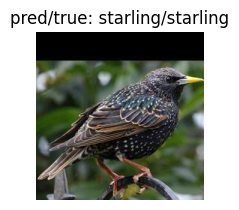

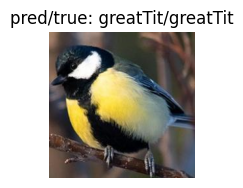

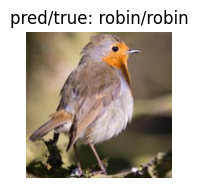

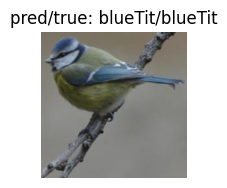

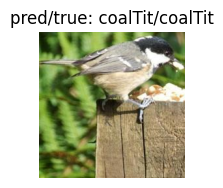

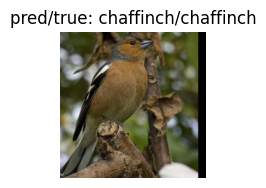

In [10]:
visualize_model(model_aug1, dataloader_tiny_val, class_labels, device)

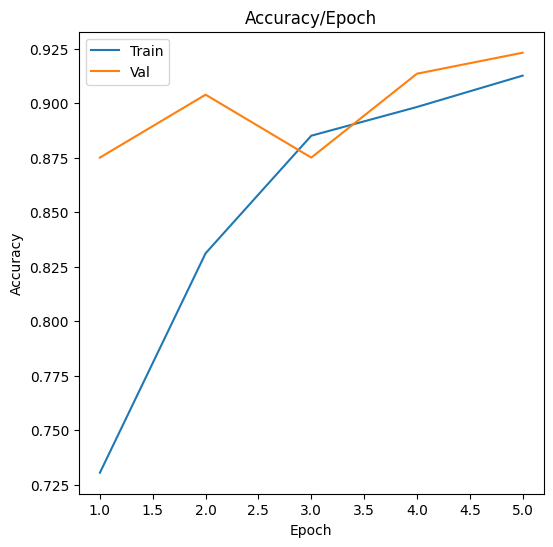

In [11]:
plot_accuracies(model_aug1_info["train_acc"], model_aug1_info["val_acc"], ["Train", "Val"])

[[14  0  0  0  1  0  0]
 [ 0 15  0  0  0  0  0]
 [ 0  0 13  0  1  0  1]
 [ 0  0  0 15  0  0  0]
 [ 0  0  1  0 13  0  1]
 [ 0  0  0  0  0 14  1]
 [ 0  0  0  0  0  0 15]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

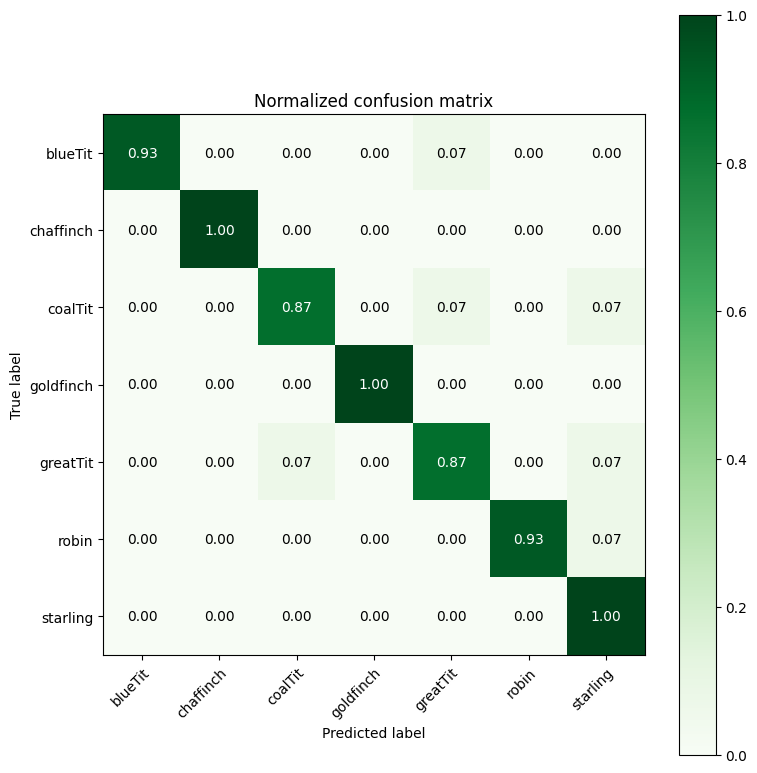

In [16]:
truel, predl = makeAll(dataloader_test, model_aug1, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)